In [62]:
import os
import numpy as np
np.random.seed(123)
from six.moves import cPickle

import keras
import tensorflow as tf

from keras import backend as K
# from keras.models import Model
from keras.layers import Input, Dense, Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam

from prednet import PredNet
# from data_utils import SequenceGenerator
from kitti_settings import *

import os
import numpy as np
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
import time

from data_utils import SequenceGenerator

In [ ]:
import hickle as hkl
import numpy as np
from keras import backend as K
from keras.preprocessing.image import Iterator

# Data generator that creates sequences for input into PredNet.

In [2]:
raw_RAD_id_list = os.listdir('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/')
print(len(raw_RAD_id_list))
RAD_id_list = raw_RAD_id_list

5000


In [3]:
def check_RAD_id(RAD_id):
    sum_list = []
    for k in range(61):
        sum_list.append(np.array(PIL.Image.open('/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png'
                         % (RAD_id, RAD_id,
                        k))).astype(np.int8).ravel().sum())
    sum_list = np.array(sum_list)
    if i % 100 == 0:
        print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
        print(i, sum_list[:7])
    if sum_list.mean() < 251001 * 0:
        return False
    for k in range(59):
        if abs(sum_list[k] + sum_list[k + 2] - 2 * sum_list[k + 1]) > 251001 * 2:
            return False
    return True

In [4]:
start_time = time.time()
print(time.strftime('start time: %Y-%m-%d %H:%M:%S', time.localtime()))
RAD_id_list = []
for (i, RAD_id) in enumerate(raw_RAD_id_list[:100]):
    if check_RAD_id(RAD_id):
        RAD_id_list.append(RAD_id)
print(time.strftime('end time: %Y-%m-%d %H:%M:%S', time.localtime()))
print(time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))
print(len(RAD_id_list))

start time: 2018-08-27 19:02:21
00:00:00
0 [-218731 -223051 -219804 -220007 -214895 -215379 -215980]
end time: 2018-08-27 19:02:25
00:00:04
36


In [79]:
class myGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, nt, image_size, image_scalar, batch_size=32, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.nt = nt
        self.image_size = image_size
        self.image_scalar = image_scalar
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        X = np.empty((self.batch_size, self.nt, self.image_size, self.image_size, 1))
        y = np.empty((self.batch_size, self.nt, self.image_size, self.image_size, 1))
        # Generate data
#         print(list_IDs_temp)
        for i, RAD_id in enumerate(list_IDs_temp):
            for j in range(self.nt):
                X[i][j] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, j * 2)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
                y[i][j] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, (j + self.nt) * 2)).resize((self.image_size, self.image_size))).astype(np.int8).reshape((self.image_size, self.image_size, 1)) / self.image_scalar
        return X, y

In [80]:
save_model = True  # if weights will be saved
weights_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_weights.hdf5')  # where weights will be saved
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')

# Data files
train_file = os.path.join(DATA_DIR, 'X_train.hkl')
train_sources = os.path.join(DATA_DIR, 'sources_train.hkl')
val_file = os.path.join(DATA_DIR, 'X_val.hkl')
val_sources = os.path.join(DATA_DIR, 'sources_val.hkl')

# Training parameters
nb_epoch = 15
batch_size = 4
samples_per_epoch = 50  # 500
N_seq_val = None  # 100  number of sequences to use for validation

# Model parameters
image_size = 256
nt = 5  # number of timesteps used for sequences in training
image_scalar = 80
n_channels, im_height, im_width = (1, image_size, image_size)  # (3, 128, 160)
input_shape = (n_channels, im_height, im_width) if K.image_data_format() == 'channels_first' else (im_height, im_width, n_channels)
stack_sizes = (n_channels, 48, 96, 192)  # (n_channels, 48, 96, 192)
R_stack_sizes = stack_sizes
A_filt_sizes = (3, 3, 3)
Ahat_filt_sizes = (3, 3, 3, 3)
R_filt_sizes = (3, 3, 3, 3)
layer_loss_weights = np.array([1., 0., 0., 0.])  # weighting for each layer in final loss; "L_0" model:  [1, 0, 0, 0], "L_all": [1, 0.1, 0.1, 0.1]
layer_loss_weights = np.expand_dims(layer_loss_weights, 1)
time_loss_weights = 1./ (nt - 1) * np.ones((nt,1))  # equally weight all timesteps except the first
time_loss_weights[0] = 0


prednet = PredNet(stack_sizes, R_stack_sizes,
                  A_filt_sizes, Ahat_filt_sizes, R_filt_sizes, A_activation='elu', error_activation='elu',
                  output_mode='prediction', return_sequences=True)

inputs = Input(shape=(nt,) + input_shape)
outputs = prednet(inputs)

def my_loss(y_true, y_pred):
    w = tf.add(y_true, tf.constant(10.0))
    loss = tf.losses.mean_squared_error(y_true, y_pred, weights=w)
#     loss = tf.losses.mean_squared_error(y_true, y_pred)
    loss = tf.multiply(loss, tf.constant(1000.0))
    return loss

# errors = prednet(inputs)  # errors will be (batch_size, nt, nb_layers)
# errors_by_time = TimeDistributed(Dense(1, trainable=False), weights=[layer_loss_weights, np.zeros(1)], trainable=False)(errors)  # calculate weighted error by layer
# errors_by_time = Flatten()(errors_by_time)  # will be (batch_size, nt)
# final_errors = Dense(1, weights=[time_loss_weights, np.zeros(1)], trainable=False)(errors_by_time)  # weight errors by time
model = keras.models.Model(inputs=inputs, outputs=outputs)
model.compile(loss=my_loss, optimizer=keras.optimizers.Adam(lr=0.001))

In [81]:
train_generator = myGenerator(list_IDs=RAD_id_list[:5], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)
valid_generator = myGenerator(list_IDs=RAD_id_list[30:], nt=nt, image_size=image_size, image_scalar=image_scalar, batch_size=1)
history = model.fit_generator(train_generator, epochs=200, validation_data=valid_generator)

Epoch 1/200
5/5 [==============================] - 6s 1s/step - loss: 118.8513 - val_loss: 17.2748
Epoch 2/200
5/5 [==============================] - 2s 324ms/step - loss: 91.0973 - val_loss: 18.0103
Epoch 3/200
5/5 [==============================] - 2s 322ms/step - loss: 84.1777 - val_loss: 21.6438
Epoch 4/200
5/5 [==============================] - 2s 315ms/step - loss: 85.3434 - val_loss: 19.0047
Epoch 5/200
5/5 [==============================] - 2s 318ms/step - loss: 80.2508 - val_loss: 18.4587
Epoch 6/200
5/5 [==============================] - 2s 327ms/step - loss: 79.8347 - val_loss: 17.0501
Epoch 7/200
5/5 [==============================] - 2s 320ms/step - loss: 76.8718 - val_loss: 17.0340
Epoch 8/200
5/5 [==============================] - 2s 319ms/step - loss: 76.5859 - val_loss: 17.8826
Epoch 9/200
5/5 [==============================] - 2s 324ms/step - loss: 76.0651 - val_loss: 17.2436
Epoch 10/200
5/5 [==============================] - 2s 330ms/step - loss: 75.0544 - val_loss:

5/5 [==============================] - 2s 336ms/step - loss: 48.1766 - val_loss: 18.3522
Epoch 82/200
5/5 [==============================] - 2s 344ms/step - loss: 47.2245 - val_loss: 18.2890
Epoch 83/200
5/5 [==============================] - 2s 342ms/step - loss: 46.1600 - val_loss: 18.6187
Epoch 84/200
5/5 [==============================] - 2s 336ms/step - loss: 46.3071 - val_loss: 19.6649
Epoch 85/200
5/5 [==============================] - 2s 338ms/step - loss: 49.7042 - val_loss: 18.0377
Epoch 86/200
5/5 [==============================] - 2s 346ms/step - loss: 49.7589 - val_loss: 18.3484
Epoch 87/200
5/5 [==============================] - 2s 340ms/step - loss: 47.6489 - val_loss: 19.1903
Epoch 88/200
5/5 [==============================] - 2s 344ms/step - loss: 48.2298 - val_loss: 17.8823
Epoch 89/200
5/5 [==============================] - 2s 343ms/step - loss: 48.9759 - val_loss: 18.0165
Epoch 90/200
5/5 [==============================] - 2s 340ms/step - loss: 50.2775 - val_loss: 1

Epoch 161/200
5/5 [==============================] - 2s 332ms/step - loss: 36.5263 - val_loss: 19.3106
Epoch 162/200
5/5 [==============================] - 2s 335ms/step - loss: 36.1909 - val_loss: 19.7369
Epoch 163/200
5/5 [==============================] - 2s 333ms/step - loss: 35.8325 - val_loss: 19.5245
Epoch 164/200
5/5 [==============================] - 2s 332ms/step - loss: 35.7634 - val_loss: 19.4565
Epoch 165/200
5/5 [==============================] - 2s 335ms/step - loss: 35.3881 - val_loss: 20.1530
Epoch 166/200
5/5 [==============================] - 2s 336ms/step - loss: 35.5221 - val_loss: 19.9691
Epoch 167/200
5/5 [==============================] - 2s 339ms/step - loss: 35.4108 - val_loss: 20.2052
Epoch 168/200
5/5 [==============================] - 2s 339ms/step - loss: 35.8704 - val_loss: 19.6384
Epoch 169/200
5/5 [==============================] - 2s 337ms/step - loss: 36.6690 - val_loss: 20.1302
Epoch 170/200
5/5 [==============================] - 2s 338ms/step - loss

In [82]:
for data in [train_generator, valid_generator][0]:
    x, y_ = data
    break
y = model.predict(x)

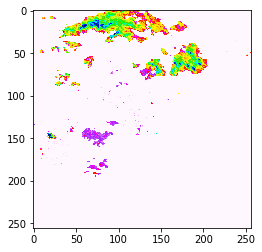

↓↓↓下面的是模型的0输出，上面的是0真实值↑↑↑


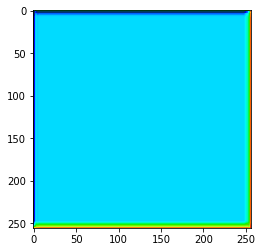

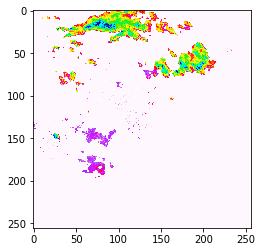

↓↓↓下面的是模型的1输出，上面的是1真实值↑↑↑


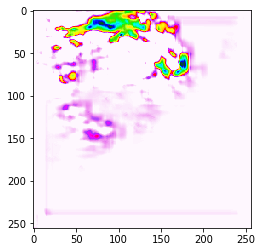

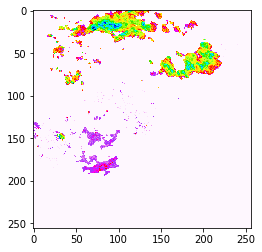

↓↓↓下面的是模型的2输出，上面的是2真实值↑↑↑


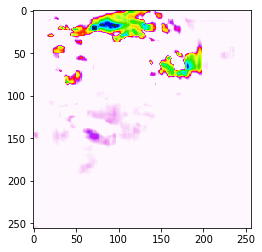

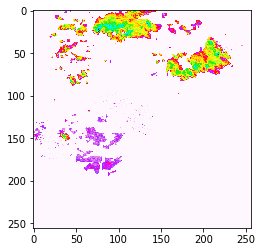

↓↓↓下面的是模型的3输出，上面的是3真实值↑↑↑


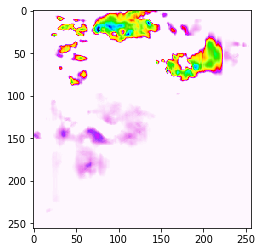

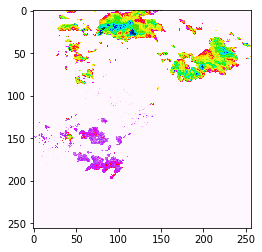

↓↓↓下面的是模型的4输出，上面的是4真实值↑↑↑


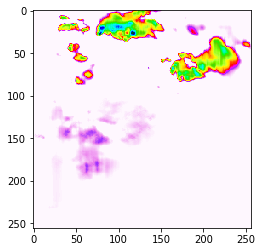

In [83]:
image_scalar = 80
for i in range(nt):
    plt.imshow(y_[0][i].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
    plt.show()
    print('↓↓↓下面的是模型的%d输出，上面的是%d真实值↑↑↑' % (i, i))
    plt.imshow(y[0][i].reshape((image_size, image_size)) * image_scalar, cmap=cm.gist_ncar_r)
    plt.show()

In [76]:
history.history

{'loss': [13533.20986328125,
  8366.716455078125,
  7893.979150390625,
  7639.204736328125,
  7684.71064453125,
  8001.662890625,
  7593.83369140625,
  7539.680102539062,
  7656.689965820313,
  7386.624560546875,
  7364.634326171875,
  7253.728100585938,
  7087.6102294921875,
  6961.21064453125,
  7021.0682373046875,
  7163.3224609375,
  7348.669848632812,
  7153.589135742188,
  7043.323779296875,
  6958.259741210937,
  6928.020751953125,
  6976.488916015625,
  6778.8052978515625,
  6633.635424804687,
  6613.549731445312,
  6872.057592773437,
  6716.039038085937,
  6633.9544921875,
  6513.092602539063,
  6356.897119140625,
  6563.3865234375,
  6758.481030273438,
  6734.504956054688,
  6694.373608398438,
  6439.887939453125,
  6316.098608398437,
  6232.8155517578125,
  6267.604467773437,
  6147.0974609375,
  6183.996728515625,
  5993.06337890625,
  6118.502685546875,
  5970.23251953125,
  5866.05859375,
  5855.068994140625,
  5626.833642578125,
  5525.27783203125,
  5558.163989257812,
 

In [ ]:
RAD_id = RAD_id_list[3]
x_matrix = np.empty((nt, image_size, image_size, 1))
for i in range(nt):
    x_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
x_matrix = x_matrix.reshape((1, nt, image_size, image_size, 1))
y_matrix = np.empty((nt, image_size, image_size, 1))
for i in range(nt):
    y_matrix[i] = np.array(PIL.Image.open("/home/hadoop/Documents/Neutrino/SRAD2018/SRAD2018_train/%s/%s_%03d.png" % (RAD_id, RAD_id, i + 10)).resize((image_size, image_size))).astype(np.int8).reshape((image_size, image_size, 1)) / SCALAR
y_matrix = y_matrix.reshape((1, nt, image_size, image_size, 1))

In [ ]:
plt.imshow(a.reshape((image_size, image_size)) * SCALAR, cmap=cm.gist_ncar_r)
plt.show()
print('↓↓↓下面的是模型的%d输出，上面的是%d真实值↑↑↑' % (1, 1))
plt.imshow(b.reshape((image_size, image_size)) * SCALAR, cmap=cm.gist_ncar_r)
plt.show()

In [ ]:
input_shape = list(model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = Input(shape=tuple(input_shape))

In [ ]:
print(x_matrix.shape)
print(y_matrix.shape)
print(a.shape)

In [ ]:
print(model.get_input_shape_at(0))
print(model.get_output_shape_at(0))

In [ ]:
%lsmagic

In [ ]:
%quickref